In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Read data

In [2]:
stroke = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data info

In [3]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Handling Missing Values

In [5]:
stroke.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Column 'bmi' have 201 missing values

<AxesSubplot:>

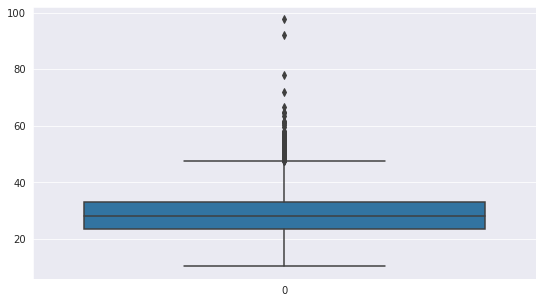

In [6]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(data=stroke['bmi'])

Imputation

In [7]:
#BMI max. 50
stroke['bmi'] = stroke['bmi'].apply(lambda x: 50 if x > 50 else x)
stroke["bmi"] = stroke["bmi"].fillna(25)
stroke.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

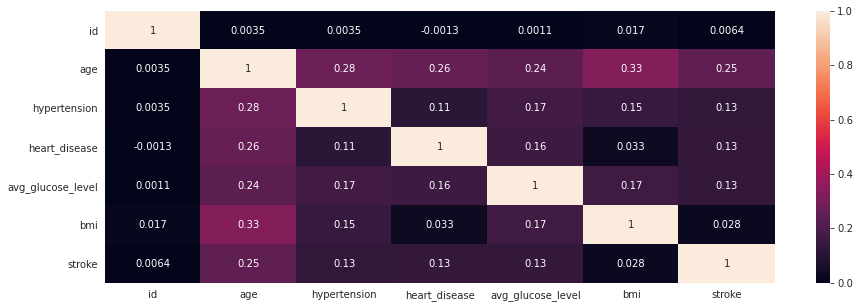

In [8]:
plt.figure(figsize=(15,5))
sns.heatmap(stroke.corr(),annot=True);

# Exploratory Data Analysis

## Person with Stroke Disease

0    4861
1     249
Name: stroke, dtype: int64


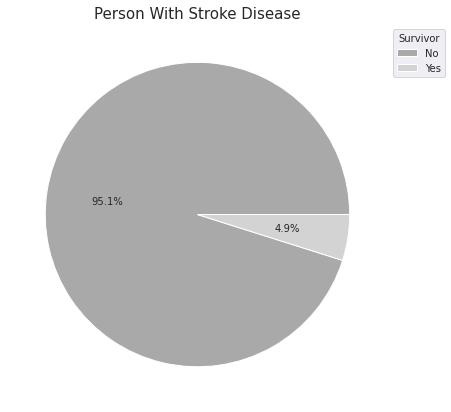

In [9]:
stroke_count = stroke['stroke'].value_counts()
print(stroke_count)
colors = ["darkgray","lightgrey"]
fig, ax = plt.subplots(figsize=(15,7))
ax.pie(stroke_count, autopct='%1.1f%%', colors=colors)
ax.set_title('Person With Stroke Disease', fontsize=15)
ax.legend(['No','Yes'],
          title='Survivor',
          bbox_to_anchor=(1,1))

## Gender Survivor and Stroke Status

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Female    141
Male      108
Name: gender, dtype: int64


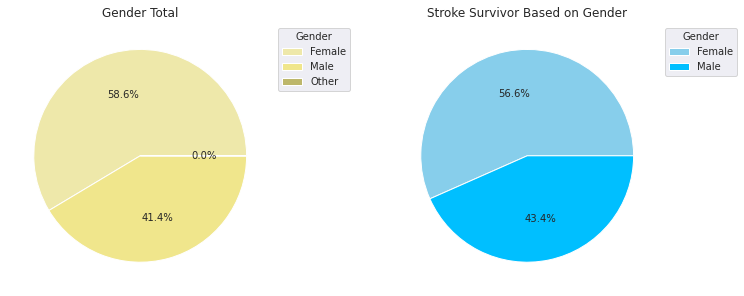

In [10]:
stroke_gndr = stroke['gender'].value_counts()
stroke_gndr_1 = stroke.loc[stroke['stroke'] == 1]
stroke_gndr_1 = stroke_gndr_1['gender'].value_counts()
print(stroke_gndr)
print(stroke_gndr_1)

fig, ax = plt.subplots(1,2,figsize=(12,7))
fig.tight_layout(pad=9)
colors = ["palegoldenrod","khaki","darkkhaki"]
ax[0].pie(stroke_gndr, autopct='%1.1f%%', colors=colors)
ax[0].set_title('Gender Total')
ax[0].legend(['Female','Male','Other'],
          title='Gender',
          bbox_to_anchor=(1,1))

colors = ["skyblue","deepskyblue"]
ax[1].pie(stroke_gndr_1, autopct='%1.1f%%', colors=colors)
ax[1].set_title('Stroke Survivor Based on Gender')
ax[1].legend(['Female','Male','Other'],
          title='Gender',
          bbox_to_anchor=(1,1))

## Stroke Survivor Based on Age

In [11]:
def group(age):
    if age >= 0 and age <= 9:
        age = "0-10"
    elif age >= 10 and age <= 19:
        age = "10-19"
    elif age >= 20 and age <= 29:
        age = "20-29"
    elif age >= 30 and age <= 39:
        age = "30-39"
    elif age >= 40 and age <= 49:
        age = "40-49"
    elif age >= 50 and age <= 59:
        age = "50-59"
    elif age >= 60 and age <= 69:
        age = "60-69"
    elif age >= 70 and age <= 79:
        age = "70-79"
    elif age >= 80 and age <= 89:
        age = "80-89"
    
    return age
    
stroke_age_gndr = stroke.loc[:,['gender','age','stroke']]
stroke_age_gndr = stroke_age_gndr.loc[stroke_age_gndr['stroke'] == 1]
stroke_age_gndr['age'] = stroke_age_gndr['age'].apply(lambda x: group(x)) 

Text(0.5, 0, 'Age')

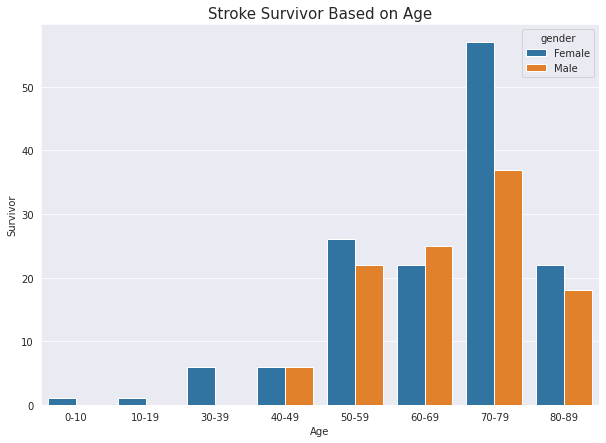

In [12]:
#ax = stroke_age_gndr.groupby(['age','gender']).count().unstack().plot.bar()
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=stroke_age_gndr.sort_values(by='age'), x='age', hue='gender')
ax.set_title('Stroke Survivor Based on Age', fontsize=15)
ax.set_ylabel('Survivor')
ax.set_xlabel('Age')

## Hypertension and Heart Disease of Stroke Survivor

0    202
1     47
Name: heart_disease, dtype: int64
0    183
1     66
Name: hypertension, dtype: int64


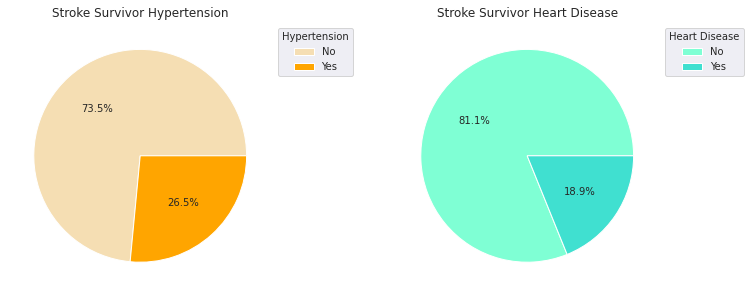

In [13]:
stroke_new = stroke.loc[stroke['stroke'] == 1]
stroke_hpy = stroke_new['hypertension'].value_counts()
stroke_hea = stroke_new['heart_disease'].value_counts()
print(stroke_hea)
print(stroke_hpy)

fig, ax = plt.subplots(1, 2,figsize=(12,7))
fig.tight_layout(pad=9)
colors = ["wheat","orange"]
ax[0].pie(stroke_hpy, autopct='%1.1f%%', colors=colors)
ax[0].set_title('Stroke Survivor Hypertension')
ax[0].legend(['No','Yes'],
          title='Hypertension',
          bbox_to_anchor=(1,1))

colors = ["aquamarine","turquoise"]
ax[1].pie(stroke_hea, autopct='%1.1f%%', colors=colors)
ax[1].set_title('Stroke Survivor Heart Disease')
ax[1].legend(['No','Yes'],
          title='Heart Disease',
          bbox_to_anchor=(1,1))

## Married Status

Yes    220
No      29
Name: ever_married, dtype: int64


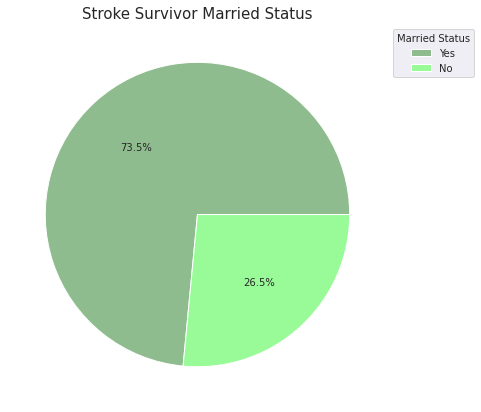

In [14]:
stroke_em = stroke_new['ever_married'].value_counts()
print(stroke_em)

fig, ax = plt.subplots(figsize=(15,7))
colors = ["darkseagreen","palegreen"]
ax.pie(stroke_hpy, autopct='%1.1f%%', colors=colors)
ax.set_title('Stroke Survivor Married Status', fontsize=15)
ax.legend(['Yes','No'],
          title='Married Status',
          bbox_to_anchor=(1,1))

## Work and Residence Type

Urban    135
Rural    114
Name: Residence_type, dtype: int64


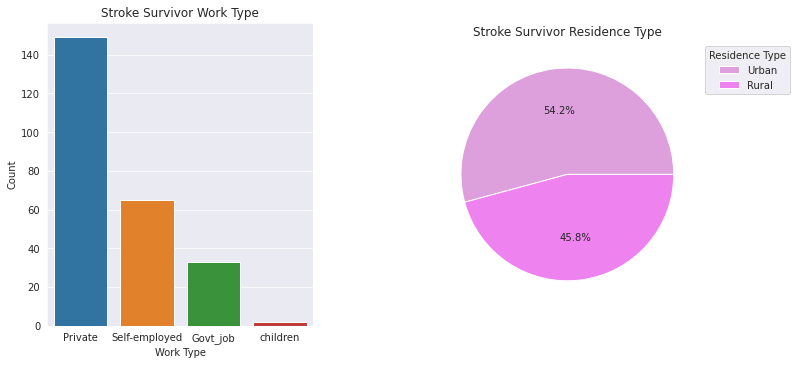

In [15]:
stroke_res = stroke_new['Residence_type'].value_counts()
print(stroke_res)

fig, ax = plt.subplots(1, 2,figsize=(12,7))
fig.tight_layout(pad=9)
colors = ["darksalmon","coral","tomato","mistyrose"]
sns.countplot(ax=ax[0], data=stroke_new, x='work_type')
ax[0].set_title('Stroke Survivor Work Type')
ax[0].set_xlabel('Work Type')
ax[0].set_ylabel('Count')

colors = ["plum","violet"]
ax[1].pie(stroke_res, autopct='%1.1f%%', colors=colors)
ax[1].set_title('Stroke Survivor Residence Type')
ax[1].legend(['Urban','Rural'],
          title='Residence Type',
          bbox_to_anchor=(1,1))

## Distribusion Avg Glucose Lv and BMI

Text(0.5, 0, 'BMI')

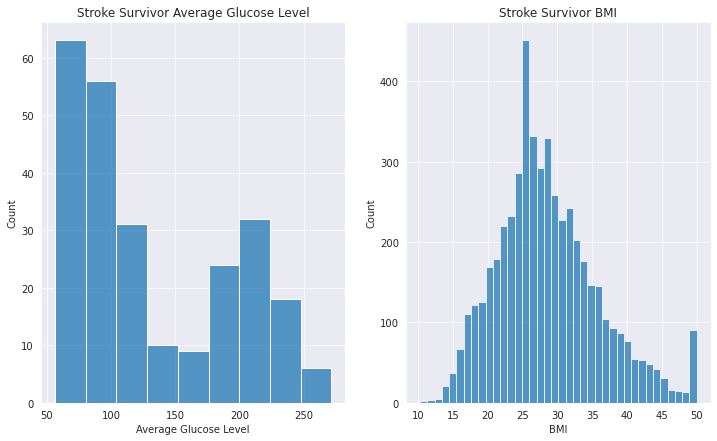

In [16]:
fig, ax = plt.subplots(1, 2,figsize=(12,7))
sns.histplot(ax=ax[0], data = stroke_new['avg_glucose_level'])
ax[0].set_title('Stroke Survivor Average Glucose Level')
ax[0].set_xlabel('Average Glucose Level')

sns.histplot(ax=ax[1], data = stroke['bmi'])
ax[1].set_title('Stroke Survivor BMI')
ax[1].set_xlabel('BMI')

## Smoking Status

Text(0.5, 0, 'Smoking Status')

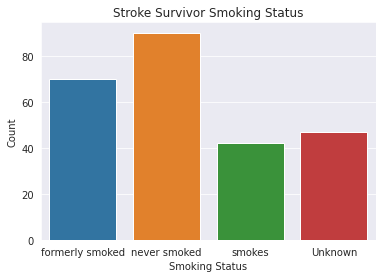

In [17]:
sns.countplot(data=stroke_new, x='smoking_status')
plt.title('Stroke Survivor Smoking Status')
plt.ylabel('Count')
plt.xlabel('Smoking Status')

# Stroke Disease Predict

In [18]:
stroke_predict = stroke.copy()
stroke_predict = stroke_predict.drop(['id'], axis=1)
stroke_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


## Encoding

In [19]:
stroke_predict['gender'] = stroke_predict['gender'].apply(lambda x: 1 if x == 'Female' else 0)
stroke_predict['ever_married'] = stroke_predict['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
stroke_predict['Residence_type'] = stroke_predict['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)
stroke_predict = pd.get_dummies(data=stroke_predict, columns=['smoking_status'])
stroke_predict = pd.get_dummies(data=stroke_predict, columns=['work_type'])

## Scaling

In [20]:
scaler = StandardScaler()
stroke_predict['age'] = scaler.fit_transform(stroke_predict[['age']])
stroke_predict['avg_glucose_level'] = scaler.fit_transform(stroke_predict[['avg_glucose_level']])
stroke_predict['bmi'] = scaler.fit_transform(stroke_predict[['bmi']])

stroke_predict.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,0,1.051434,0,1,1,1,2.706375,1.082204,1,0,1,0,0,0,0,1,0,0
1,1,0.786070,0,0,1,0,2.121559,-0.495339,1,0,0,1,0,0,0,0,1,0
2,0,1.626390,0,1,1,0,-0.005028,0.524624,1,0,0,1,0,0,0,1,0,0
3,1,0.255342,0,0,1,1,1.437358,0.783015,1,0,0,0,1,0,0,1,0,0
4,1,1.582163,1,0,1,0,1.501184,-0.631334,1,0,0,1,0,0,0,0,1,0


## Build Model

In [21]:
X = stroke_predict.drop(['stroke'], axis=1)
y = stroke_predict['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Fit Model

#### Decision Tree

In [22]:
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))
train_score1 = model.score(X_train, y_train)
test_score1 = model.score(X_test, y_test) 

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(cm)
print(cr)

Training Score:  1.0
Test Score:  0.903457273320287
[[1375   86]
 [  62   10]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1461
           1       0.10      0.14      0.12        72

    accuracy                           0.90      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.92      0.90      0.91      1533



#### Logistic Regression

In [23]:
model = LogisticRegression()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))
train_score2 = model.score(X_train, y_train)
test_score2 = model.score(X_test, y_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(cm)
print(cr)

Training Score:  0.950796757058988
Test Score:  0.9530332681017613
[[1461    0]
 [  72    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1461
           1       0.00      0.00      0.00        72

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.91      0.95      0.93      1533



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Random Forest

In [24]:
model = RandomForestClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))
train_score3 = model.score(X_train, y_train)
test_score3 = model.score(X_test, y_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(cm)
print(cr)

Training Score:  1.0
Test Score:  0.9510763209393346
[[1456    5]
 [  70    2]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1461
           1       0.29      0.03      0.05        72

    accuracy                           0.95      1533
   macro avg       0.62      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533



#### XGB Classifier

In [25]:
model = XGBClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))
train_score4 = model.score(X_train, y_train)
test_score4 = model.score(X_test, y_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(cm)
print(cr)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score:  0.9966452334358401
Test Score:  0.9425962165688193
[[1441   20]
 [  68    4]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1461
           1       0.17      0.06      0.08        72

    accuracy                           0.94      1533
   macro avg       0.56      0.52      0.53      1533
weighted avg       0.92      0.94      0.93      1533



#### Gradient Boosting Classifier

In [26]:
model = GradientBoostingClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))
train_score5 = model.score(X_train, y_train)
test_score5 = model.score(X_test, y_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(cm)
print(cr)

Training Score:  0.9594632373497344
Test Score:  0.9504240052185258
[[1455    6]
 [  70    2]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1461
           1       0.25      0.03      0.05        72

    accuracy                           0.95      1533
   macro avg       0.60      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533



#### Bagging Classifier

In [27]:
model = BaggingClassifier()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Training Score: ", model.score(X_train, y_train))
print("Test Score: ", model.score(X_test, y_test))
train_score6 = model.score(X_train, y_train)
test_score6 = model.score(X_test, y_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(cm)
print(cr)

Training Score:  0.9888174447861336
Test Score:  0.9425962165688193
[[1442   19]
 [  69    3]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1461
           1       0.14      0.04      0.06        72

    accuracy                           0.94      1533
   macro avg       0.55      0.51      0.52      1533
weighted avg       0.92      0.94      0.93      1533



# Result (Accuracy and Training Score)

In [28]:
print("Decision Tree\nTraining Score:", train_score1, "\nAccuracy:", test_score1)
print("\nLogistic Reggresion\nTraining Score:", train_score2, "\nAccuracy:", test_score2)
print("\nRandom Forest\nTraining Score:", train_score3, "\nAccuracy:", test_score3)
print("\nXGB Classifier\nTraining Score:", train_score4, "\nAccuracy:", test_score4)
print("\nGradient Boosting Classifier\nTraining Score:", train_score5, "\nAccuracy:", test_score5)
print("\nBagging Classifier\nTraining Score:", train_score6, "\nAccuracy:", test_score6)

Decision Tree
Training Score: 1.0 
Accuracy: 0.903457273320287

Logistic Reggresion
Training Score: 0.950796757058988 
Accuracy: 0.9530332681017613

Random Forest
Training Score: 1.0 
Accuracy: 0.9510763209393346

XGB Classifier
Training Score: 0.9966452334358401 
Accuracy: 0.9425962165688193

Gradient Boosting Classifier
Training Score: 0.9594632373497344 
Accuracy: 0.9504240052185258

Bagging Classifier
Training Score: 0.9888174447861336 
Accuracy: 0.9425962165688193
